In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import h5py

In [2]:
def min_dist_angle(position, direction, box_size):
    #which wall is it close to?
    x, y = position
    dists = np.abs([box_size-x, box_size-y, box_size+x, box_size+y])
    d_wall = np.min(dists)
    a_wall_vec = (direction - np.pi*np.arange(4) / 2)
    a_wall_vec[0] = a_wall_vec[0] % (3*np.pi/2) #modulo 2pi
    a_wall = a_wall_vec[np.argmin(dists)]
    return d_wall, a_wall

In [4]:
dt = 0.02 #time step increment (seconds)
samples = int(200/dt) #number of time points
box_size = 2.2 / 2 #meters
border_region = 0.03 #meters

turn_angle = 0

mu = 0
sigma = 5.76 #stdev rotation velocity (rads/sec)
b = 0.13 #forward velocity rayleigh dist scale (m/sec)

In [5]:
# random velocity samples
def generate_trajectory():
    v = np.random.rayleigh(b);
    #initialize variables
    position = np.zeros([samples+1, 2])
    head_dir = np.zeros(samples+1)
    position[0] = np.random.uniform(-box_size,box_size, 2)
    head_dir[0] = np.random.uniform(0,2*np.pi)
    ego_v = np.zeros(samples+1)
    
    #generate sequence of random boosts and turns
    random_turn = np.random.normal(mu, sigma, samples+1)
    random_vel = np.random.rayleigh(b, samples+1)
    
    for i in range(1,samples+1):
        #If in border region, turn and slow down
        d_wall, a_wall = min_dist_angle(position[i-1], head_dir[i-1] % (2*np.pi), box_size)
        if d_wall < border_region and np.abs(a_wall) < np.pi/2:
            turn_angle = np.sign(a_wall)* np.pi/2 + dt*random_turn[i]
            v -= 0.25*v
        else:
            v = random_vel[i]
            turn_angle = dt*random_turn[i]
        #Take a step
        ego_v[i-1] = v*dt
        position[i] = position[i-1] + ego_v[i-1]*np.asarray([np.cos(head_dir[i-1]), np.sin(head_dir[i-1])])
        #Rotate head direction
        head_dir[i] = (head_dir[i-1] + turn_angle) 
    ang_velocity = np.diff(head_dir)
    theta_x, theta_y = np.cos(ang_velocity), np.sin(ang_velocity)
    head_dir = head_dir % (2*np.pi) - np.pi #Constrain head_dir to interval (-pi, pi)
    return position[:-1,0], position[:-1, 1], head_dir[:-1], ego_v[:-1], theta_x, theta_y

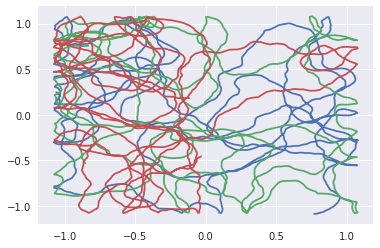

In [11]:
for i in range(3):
    sample_traj = generate_trajectory()
    plt.plot(sample_traj[0], sample_traj[1])

In [20]:
#Generate dataset
num_trajectories = 800
x = []
y = []
head_dir = []
ego_v = []
theta_x = []
theta_y = []
i = 0
while len(x) < num_trajectories*samples - 1:
    new_traj = generate_trajectory()
    if np.all(np.abs(new_traj[0]) < 1.1) and np.all(np.abs(new_traj[1]) < 1.1):
        x = np.append(x, new_traj[0])
        y = np.append(y, new_traj[1])
        head_dir = np.append(head_dir, new_traj[2])
        ego_v = np.append(ego_v, new_traj[3])
        theta_x = np.append(theta_x, new_traj[4])
        theta_y = np.append(theta_y, new_traj[5])
        i += 1
    if i % 100 == 0:
        print(i)

100
200
300
400
500
600
700
800


In [21]:
data_dict = dict(x=x, y=y, head_dir=head_dir, ego_v=ego_v, theta_x=theta_x, theta_y=theta_y)

In [23]:
#Save data
with h5py.File('mouse_simulation_data.h5', 'w') as f:
    for key, val in data_dict.items():
        f.create_dataset(key, data=val)

In [24]:
f.close()

In [35]:
f = h5py.File('mouse_simulation_data.h5', 'r')

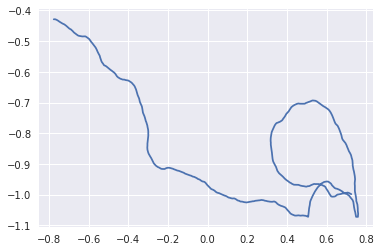

In [36]:
x = f['x']
y = f['y']
plt.plot(x[:1000], y[:1000])

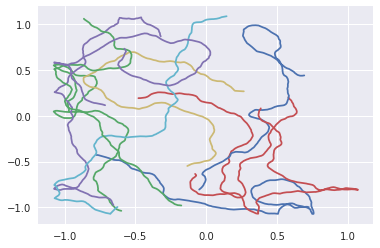

In [40]:
for i in range(10):
    plt.plot(x[1000*i:1000*(i+1)], y[1000*i:1000*(i+1)])

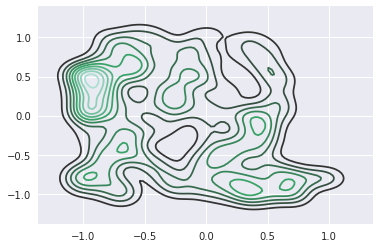

In [45]:
sns.kdeplot(x[:10000], y[:10000])

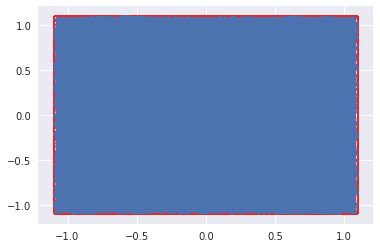

In [33]:
plt.plot(x,y)
plt.hlines([-1.1,1.1], -1.1,1.1, color='r')
plt.vlines([-1.1,1.1], -1.1,1.1, color='r')

## Tests

(array([1.47960e+05, 3.05428e+05, 2.85760e+05, 1.67844e+05, 6.83180e+04,
        1.98620e+04, 4.08000e+03, 6.81000e+02, 6.20000e+01, 5.00000e+00]),
 array([1.13277317e-11, 1.41143102e-03, 2.82286204e-03, 4.23429305e-03,
        5.64572406e-03, 7.05715507e-03, 8.46858608e-03, 9.88001710e-03,
        1.12914481e-02, 1.27028791e-02, 1.41143101e-02]),
 <a list of 10 Patch objects>)

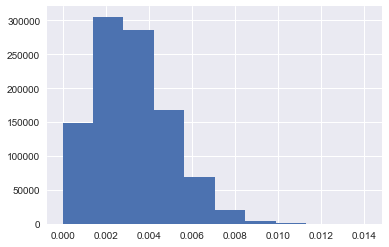

In [41]:
plt.hist(ego_v)

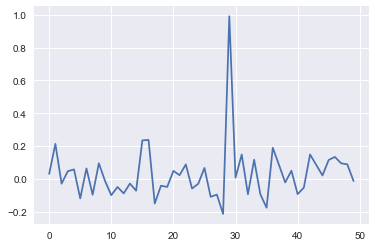

In [49]:
plt.plot(theta_y[350:400])

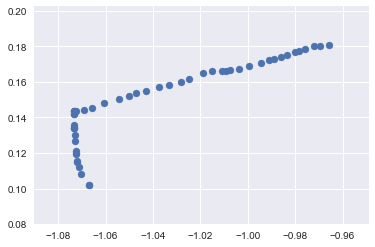

In [52]:
plt.scatter(x[350:400], y[350:400])

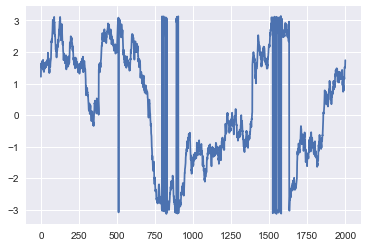

In [34]:
plt.plot(head_dir[:2000])

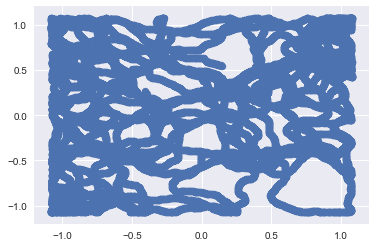

In [20]:
plt.scatter(x[:30000],y[:30000])

In [8]:
dt = 0.02 #time step increment (seconds)
samples = int(100/dt) #number of time points
box_size = 2.2 / 2 #meters
border_region = 0.03 #meters

position = np.zeros([samples+2, 2])
head_dir = np.zeros(samples+2)
turn_angle = 0

mu = 0
sigma = 5.76 #stdev rotation velocity (rads/sec)
b = 0.13 #forward velocity rayleigh dist scale (m/sec)

In [9]:
v = 0.2;

#initialize position and head direction randomly
position[0] = np.random.uniform(-box_size,box_size,2)
head_dir[0] = np.random.uniform(0,2*np.pi)

#generate sequence of random boosts and turns
random_turn = np.random.normal(mu, sigma, samples+2)
random_vel = np.random.rayleigh(b, samples+2)

for i in range(1,samples+2):
    #If in border region, turn and slow down
    d_wall, a_wall = min_dist_angle(position[i-1], head_dir[i-1] % (2*np.pi), box_size)
    if d_wall < border_region and np.abs(a_wall) < np.pi/2:
        turn_angle = np.sign(a_wall)*(np.pi/2 - np.abs(a_wall)) + dt*random_turn[i]
        v = 0.25*v
    else:
        v = random_vel[i]
        turn_angle = dt*random_turn[i]
    #Take a step
    ego_velocity[i-1] = v*dt
    position[i] = position[i-1] + ego_velocity[i-1]*np.asarray([np.cos(head_dir[i-1]), np.sin(head_dir[i-1])])
    #Rotate head direction
    head_dir[i] = (head_dir[i-1] + turn_angle) 
ang_velocity = np.diff(head_dir)
theta_x, theta_y = np.cos(ang_velocity), np.sin(ang_velocity)
head_dir = head_dir % (2*np.pi) #Constrain head_dir to interval (0, 2pi)
x = position[:,0]
y = position[:,1]

NameError: name 'ego_velocity' is not defined

In [37]:
idx = 4
#Can we reconstuct head direction from angular velocity?
head_dir_guess = head_dir[idx] + np.arctan(theta_y[idx]/theta_x[idx])
print('head dir guess = ' + str(head_dir_guess))
print('true head dir  = ' + str(head_dir[idx+1]))

#Can we reconstruct position from ego_v and angular velocity?
position_guess = position[idx] + ego_velocity[idx]*np.asarray([np.cos(head_dir[idx]), np.sin(head_dir[idx])])
print('position guess =' + str(position_guess))
print('true position = ' + str(position[idx+1]))

head dir guess = 3.051220736603194
true head dir  = 3.051220736603194
position guess =[-0.99076104 -0.46024195]
true position = [0. 0.]
